In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from sklearn import metrics
import matplotlib.pyplot as plt
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.legacy import data
from torchtext import datasets
from torchtext.legacy.data import Field, Dataset, Example
from torch.autograd import Variable

Load the pre-trained embedding matrix

*   glove-twitter-200d
*   ntua-twitter-300d
*   concatenate the two, make 500d

.npy file is the binary numpy matrix file, which stores the pre-trained weights used for Embedding layer.

token_idx.csv: the corresponding dic index of the tokens in each input tweet, varied-length, needs padding to the same length before training.


In [ ]:
glove_weights = np.load("/content/drive/MyDrive/irony_thuset/glove_twitter_embed_matrix.npy")
ntua_weights = np.load("/content/drive/MyDrive/irony_thuset/ntua_twitter_embed_matrix.npy")

glove_weights = torch.from_numpy(glove_weights)
ntua_weights = torch.from_numpy(ntua_weights)
glove_weights = torch.cat((glove_weights, ntua_weights), dim=1)
print("Embedding dimension:", glove_weights.size())

Embedding dimension: torch.Size([1175, 500])


Obtain the token index table, used as input of the embeddding layer in self.forward()


*   Specifically, a token index table is that:
for each tweet, we need the token index extracted from a whole word dictionary in the whole set
tweet: "I have a dog" ;     token index: [3, 6, 8, 9]



In [ ]:
def idx_tensor(path, reshape_size):
  token_idx = pd.read_csv(path, index_col=None)
  token_idx["token_to_idx"] = token_idx.loc[:, "token_to_idx"].map(lambda x: ast.literal_eval(x))
  token_idx["token_length"] = token_idx["token_to_idx"].map(lambda x: len(x))
  print("Max length of the tokens:", token_idx["token_length"].max())

  # So we pad all inputs to same length tokens, pad with index 1174 which is the <unk> token index
  idx_matrix = []
  for i in range(len(token_idx)):
    l = token_idx.loc[i, "token_to_idx"]
    l += (token_idx["token_length"].max()-len(l)) * [1174]
    idx_matrix.extend(l)
  idx_matrix = np.array(idx_matrix).reshape(reshape_size, -1) 
  idx_tensor = torch.from_numpy(idx_matrix).long()
  return idx_tensor

In [ ]:
idx_train = idx_tensor("/content/drive/MyDrive/irony_thuset/token_idx.csv", 3834)
idx_test = idx_tensor("/content/drive/MyDrive/irony_thuset/token_idx_test.csv", 784)

Max length of the tokens: 75
Max length of the tokens: 66


# 1. Import pre-trained embeddings and labels, train and gold-test

set cuda configuration

In [ ]:
torch.manual_seed(16)    # Group 16
cuda_status = torch.cuda.is_available()

# using cuda
if cuda_status:
    torch.cuda.manual_seed(100)
    device = 'cuda:0'
    print('You have CUDA device.')
else:
    device = 'cpu'
    print('Switch to GPU runtime to speed up computation.')  

You have CUDA device.


In [ ]:
with open('/content/drive/MyDrive/irony_thuset/task3_train.txt','r')as f:
    task3_train = f.read()
task3_train = json.JSONDecoder().decode(task3_train)

train_label = []
for sent in task3_train:
    train_label.append(int(sent['label']))
train_label = np.array(train_label, dtype=np.float)
train_label = torch.from_numpy(train_label).long()

# gold test labels
gold_test_df = pd.read_csv("/content/drive/MyDrive/irony_thuset/SemEval2018-T3_gold_test_taskA_emoji.txt", sep="\t")
test_label = gold_test_df["Label"]
true_labels = np.array(test_label)
test_label = torch.from_numpy(true_labels).long()


print("train_label:", train_label.shape)
print("test_label:", test_label.shape)

train_label: torch.Size([3834])
test_label: torch.Size([784])


# 2. Construct data iteretors with batch-size

In [ ]:
BATCH_SIZE = 64

train_set = idx_train, train_label
test_set = idx_test, test_label

# Create dataloaders from the training and test set for easier iteration over the data
train_loader = DataLoader(TensorDataset(*train_set), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(*test_set), batch_size=BATCH_SIZE)


# 3. Build the bi-LSTM with customized number of layers

In [ ]:
class BiLSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embed_size, weights_matrix, hidden_dim, dropout, num_layers):
  
        super(BiLSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': weights_matrix})
        
        
        self.lstm = nn.LSTM(embed_size, hidden_dim, bidirectional=True, num_layers=num_layers, dropout = dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)
        self.dropout = nn.Dropout(dropout)


    def forward(self, idx):

        #pass pre-trained embeddings through embedding layer
        embedded = self.embedding(idx)
        #pass embeddings into LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded) # h0, c0 both intialized to zero
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        
        outputs = self.fc(self.dropout(cat))
        return outputs



# 4. Define train and test module

In [ ]:
def train(train_loader, model, loss_function, optimizer, device):
  """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer.
        loss_function: Loss function (e.g. cross-entropy loss).
  """

  avg_loss = 0
  correct = 0
  total = 0
    # Iterate through batches
  for i, data in enumerate(train_loader):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # Move data to target device
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + backward + optimize

      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()

      # Keep track of loss and accuracy
      avg_loss += loss
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return avg_loss / len(train_loader), 100 * correct / total

def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    """

    avg_loss = 0
    correct = 0
    total = 0
    pred_labels = []
    
    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in test_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move data to target device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pred_labels.append(predicted)

    return avg_loss / len(test_loader), 100 * correct / total, pred_labels



# 5. Train process

In [ ]:

DROPOUT = 0.3
HIDDEN_SIZE = 200
EPOCH = 80
LEARNING_RATE = 0.0005
NUM_LAYERS = 4
EMBED_SIZE = glove_weights.shape[1]
VOCAB_SIZE = glove_weights.shape[0]
WEIGHTS_MATRIX = glove_weights


model = BiLSTMClassifier(VOCAB_SIZE, EMBED_SIZE, WEIGHTS_MATRIX, HIDDEN_SIZE, DROPOUT, NUM_LAYERS)
model = model.to(device)
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


train_losses = []
train_accs = []
test_losses = []
test_accs=[]

# training process
for epoch in tqdm(range(EPOCH)):
    
    train_loss, train_acc = train(train_loader, model, loss_function, optimizer, device)  
    test_loss, test_acc, pred_labels = test(test_loader, model, loss_function, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
  


100%|██████████| 80/80 [06:43<00:00,  5.04s/it]


# 6. Draw the train and test curves. Evaluate confusion matrix

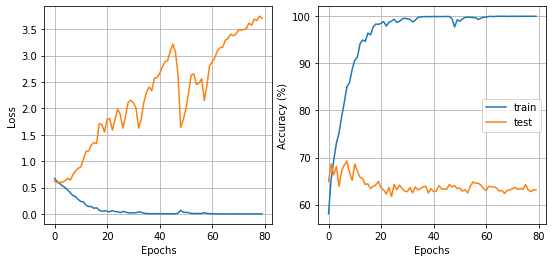

In [ ]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = "train")
plt.plot(test_accs, label = "test")
plt.legend()
plt.grid()

In [ ]:
pre_l = []
for i in pred_labels:
  pre_l.extend(i.to("cpu").numpy().tolist())
pre_l = np.array(pre_l)

print("Precision (P):", metrics.precision_score(true_labels, pre_l))
print("Recall (R):", metrics.recall_score(true_labels, pre_l))
print("F1 score (F):", metrics.f1_score(true_labels, pre_l))
print()
print("Classification Report")
print(metrics.classification_report(true_labels, pre_l, digits=4))

Precision (P): 0.5307262569832403
Recall (R): 0.6109324758842444
F1 score (F): 0.5680119581464873

Classification Report
              precision    recall  f1-score   support

           0     0.7160    0.6448    0.6785       473
           1     0.5307    0.6109    0.5680       311

    accuracy                         0.6314       784
   macro avg     0.6233    0.6279    0.6233       784
weighted avg     0.6425    0.6314    0.6347       784

